In [32]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

file_path = 'MJD_Train_0.hdf5'

In [33]:
with h5py.File(file_path, 'r') as f:
    print('Datasets available in the file: ')
    for key in f.keys():
        print(key)

Datasets available in the file: 
detector
energy_label
id
psd_label_dcr
psd_label_high_avse
psd_label_low_avse
psd_label_lq
raw_waveform
run_number
tp0


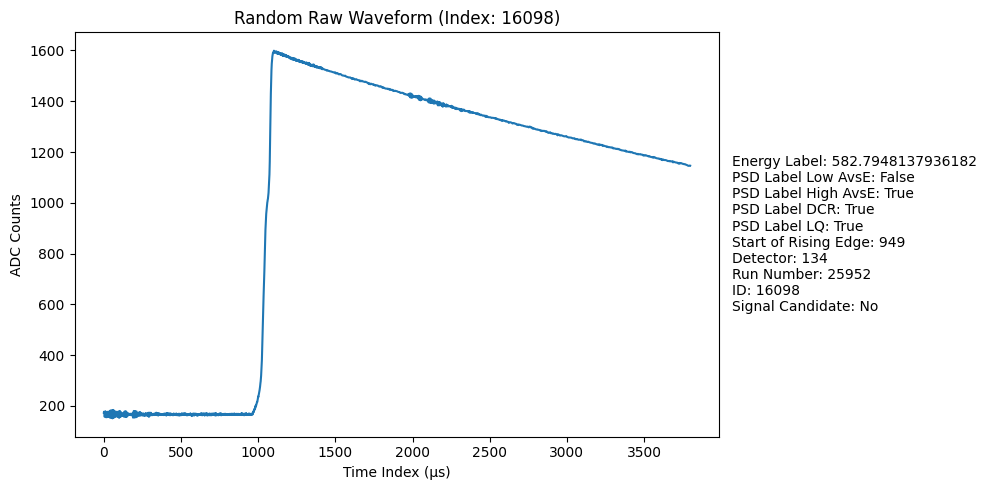

In [34]:
with h5py.File(file_path, 'r') as f:
    # Load Waveform
    raw_waveform = np.array(f['raw_waveform'])

    # Load Labels
    energy_label = np.array(f['energy_label'])
    psd_label_low_avse = np.array(f['psd_label_low_avse'])
    psd_label_high_avse = np.array(f['psd_label_high_avse'])
    psd_label_dcr = np.array(f['psd_label_dcr'])
    psd_label_lq = np.array(f['psd_label_lq'])
    tp0 = np.array(f['tp0'])
    detector = np.array(f['detector'])
    run_number = np.array(f['run_number'])
    id = np.array(f['id'])

    # Get Index
    idx = np.random.choice(raw_waveform.shape[0])

    # Index Waveform
    idx_waveform = raw_waveform[idx]

    # Index Labels
    energy_value = energy_label[idx]
    psd_low_avse_value = psd_label_low_avse[idx]
    psd_high_avse_value = psd_label_high_avse[idx]
    psd_dcr_value = psd_label_dcr[idx]
    psd_lq_value = psd_label_lq[idx]
    tp0_value = tp0[idx]
    detector_value = detector[idx]
    run_number_value = run_number[idx]
    id_value = id[idx]

    # Determine Signal Candidate
    # energy_threshold = 0
    is_signal_candidate = (
        # energy_value > energy_threshold and
        psd_low_avse_value and
        psd_high_avse_value and
        psd_dcr_value and
        psd_lq_value
    )

    
    # Plot Figure
    plt.figure(figsize=(10, 5))
    plt.plot(idx_waveform)
    plt.title(f"Random Raw Waveform (Index: {id_value})")
    plt.xlabel("Time Index (µs)")
    plt.ylabel("ADC Counts")

    # Display Labels
    label_text = (
        f"Energy Label: {energy_value}\n"
        f"PSD Label Low AvsE: {'True' if psd_low_avse_value else 'False'}\n"
        f"PSD Label High AvsE: {'True' if psd_high_avse_value else 'False'}\n"
        f"PSD Label DCR: {'True' if psd_dcr_value else 'False'}\n"
        f"PSD Label LQ: {'True' if psd_lq_value else 'False'}\n"
        f"Start of Rising Edge: {tp0_value}\n"
        f"Detector: {detector_value}\n"
        f"Run Number: {run_number_value}\n"
        f"ID: {id_value}\n"
        f"Signal Candidate: {'Yes' if is_signal_candidate else 'No'}"
    )
    plt.text(1.02, 0.5, label_text, transform=plt.gca().transAxes, verticalalignment='center')
    plt.tight_layout()
    plt.show()


In [35]:
def get_tdrift50(waveform, start_idx = 1000):

    # Find the index of the peak value
    max_idx = np.argmax(waveform)

    # Calculate the middle y-value (50%) between start and max
    start_y = waveform[start_idx]
    max_y = waveform[max_idx]
    mid_y = (start_y + max_y) / 2

    # Find the x-value (index) where the waveform crosses the middle y-value
    mid_x_idx = start_idx + np.argmax(idx_waveform[start_idx:max_idx] >= mid_y)

    tdrift50 = mid_x_idx - start_idx 

    print(f" Start X value: {start_idx}\n",f"50% X value: {mid_x_idx}\n",f"tdrift50: {tdrift50}\n")

    return int(tdrift50)

In [36]:
idx = np.random.choice(raw_waveform.shape[0])
idx_waveform = raw_waveform[idx]

get_tdrift50(idx_waveform)

 Start X value: 1000
 50% X value: 1064
 tdrift50: 64



64

In [37]:
# DCR is calculated by finding the area above the tail slope

peak_idx = np.argmax(idx_waveform)
peak_val = int(idx_waveform[peak_idx])
data_after_peak = idx_waveform[peak_idx:]
time_indices = np.arange(peak_idx, len(idx_waveform))
area_above_tail_slope = np.trapezoid(peak_val - data_after_peak, x=time_indices) 

print("Peak value:", peak_val)
print("Area above the curve after the peak:", area_above_tail_slope)

Peak value: 6525
Area above the curve after the peak: 2975481.625


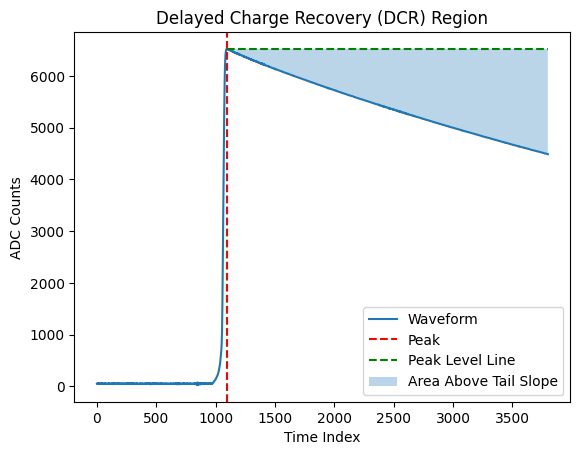

In [38]:
plt.plot(idx_waveform, label="Waveform")
plt.axvline(x=peak_idx, color='r', linestyle='--', label="Peak")
plt.hlines(peak_val, peak_idx, len(idx_waveform)-1, colors='g', linestyles='--', label="Peak Level Line")
plt.fill_between(time_indices, data_after_peak, peak_val, where=(data_after_peak < peak_val),
                 alpha=0.3, label="Area Above Tail Slope")
plt.xlabel("Time Index")
plt.ylabel("ADC Counts")
plt.legend()
plt.title("Delayed Charge Recovery (DCR) Region")
plt.show()

In [39]:
def find_dcr(waveform):

    # Find peak index value
    peak_idx = np.argmax(waveform)

    # Find peak value
    peak_val = int(waveform[peak_idx])

    # We are only looking at the data after the peak
    data_after_peak = waveform[peak_idx:]

    # Get all time indices between peak and end of the time series
    time_indices = np.arange(peak_idx, len(waveform))

    # Calculate DCR region
    area_above_tail_slope = np.trapezoid(peak_val - data_after_peak, x=time_indices) 
    
    return area_above_tail_slope